#Lecture 9: Gibbs Sampling

AM207: Pavlos Protopapas, Harvard University

Feb 25 2014


------


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

$$
\newcommand{\var}{{\rm var}}
\newcommand{\cov}{{\rm cov}}
\newcommand{\corr}{{\rm corr}}
\newcommand{\xss}{x^{(i+1)}}
\newcommand{\xs}{x^{\star}}
\newcommand{\xt}{x^{(i)}}
\newcommand{\yss}{y^{(i+1)}}
\newcommand{\ys}{y^{\star}}
\newcommand{\yt}{y^{(i)}}
\newcommand{\xa}{x_a}
\newcommand{\xb}{x_b}
$$

#A little history

(From Tanner and Wong, 2010)

In 1984, Geman and Geman published a paper on the topic of Bayesian image analysis (Geman and Geman, 1984). Beyond its immediate and large impact in image analysis, this paper is significant for several results of more general interest, including a proof of the convergence of simulated annealing, and the introduction of the Gibbs sampler.

The authors began by drawing an analogy between images and statistical mechanics systems. Pixel gray levels and edge elements were regarded as random variables and an energy function based on local characteristics of the image was used to represent prior information on the image such as piece-wise smoothness. 

Because interaction energy terms involved only local neighbors, the conditional distribution of a variable given the remaining components of the image depends only on its local neighbors, and is therefore easy to sample from. Such a distribution, for the systems of image pixels, is similar to the canonical distribution in statistical mechanics studied by Boltzmann and Gibbs, and it is thus called a Gibbs distribution for the image.

Next, the authors analyzed the statistical problem of how to restore the image from an observed image which is a degradation of true image through the processes of local blurring and noise contamination. They showed that the posterior distribution of true image given the observed data is also a Gibbs distribution whose energy function still involves only local interactions. Geman and Geman proposed to generate images from this posterior distribution by iteratively sampling each image element from its conditional distribution given the rest of the image, which is easy to do because the distribution is still Gibbs. They call this iterative conditional sampling algorithm the Gibbs sampler.

#Introduction
As we saw already it is not always easy to tune the proposal distribution. The Gibbs sampler
is a procedure for multivariate distributions 
in which all samples are accepted therefore we do not have to specify a proposal
distribution, leaving some guessing work out of the MCMC procedure.
However, the Gibbs sampler can only be applied in situations where we know the full
conditional distributions of each component in the multivariate distribution conditioned on
all other components. In some cases, these conditional distributions are  not known,
and Gibbs sampling cannot be applied. In many cases though these  distributions
are known and Gibbs sampling is an extremely fast and efficient approach. 

Assume we have a bivariate distribution where we have a joint distribution $p(x_1,x_2)$. 
For Gibbs sampler to work, we must be able to derive the conditional distributions 
$p(x_1| x_2=x_2^{(i)})$ and $p(x_2| x_1=x_1^{(i)})$. That is, the distribution of
each variable conditioned on a specific realization of the other variable. And of course
it is required that we can sample from these distributions.


##Sampling From Conditionals

Imagine your posterior distribution has the following functional form:

$$ f(x, y) =  \frac{1}{C} e^{-\frac{(x^2 \,y^2+x^2+y^2-8x-8y)}{2}} $$

As is typical in Bayesian inference, you don't know what C (the normalizing constant) is, so you can't sample from this distribution using conventional methods. However, MCMC techniques allow us to sample from probability distributions without knowing this constant, and we will use one particular MCMC technique, Gibbs sampling, to do this here.

Gibbs sampling allows you to sample from a probability distribution by iteratively sampling from its **conditional** distributions. This strategy is very useful in problems where each unknown would have a very simple distribution if we knew all of the other unknowns. In this problem, the posterior distribution $f(x, y)$ is over two unknowns, $x$ and $y$. To perform Gibbs sampling, we sample from the distribution of $x$ holding $y$ constant at its current value, then sample from the distribution of $y$ holding $x$ constant at its current value. As it turns out, even though $f(x, y)$ is incredibly ugly, the conditional distributions are relatively simple.

After some simplification (completing the square and throwing all factors that do not involve $x$ into $g(y)$ for the first equation, and vice versa for the second), we find that the conditional distributions have a relatively simple form.

$$ p(x \mid y) = g(y) e^{-\left(x-\frac{4}{(1+y^2)}\right)^{2}\frac{(1+y^2)}{2}} $$

and

$$ p(y \mid x) = g(x) e^{-\left(y-\frac{4}{(1+x^2)}\right)^{2}\frac{(1+x^2)}{2}} $$

What are these distributions? They are in fact normals. Writing this in distributional notation,

$$ x \mid y \sim N\left(\frac{4}{1+y^2}, \sqrt{\frac{1}{1+y^2}}\right) $$

and similarly

$$ y \mid x \sim N\left(\frac{4}{1+x^2}, \sqrt{\frac{1}{1+x^2}}\right) $$

We know how to draw from normal distributions, so if we iterate back and forth, we should be able to sample from $f(x, y )$.

We first initialize the sampler with initial values and at each iteration $i$, we 
we sample first a new value for $\xss_1$  that is conditional to $\xt_2$,
the previous step of the second component and we do that by drawing from 
$p(x_1|x_2=\xt_2)$. In contrast with MH, we will always accept this proposal.
The new state is updated immediately without checking the acceptance probability. 
In the next step, we sample a new value of $\xss_2$ conditional on $\xss_1$, which is 
the current step of the first component.
The procedure is iterative conditional sampling; we go back and forth by sampling the new 
state by conditioning on the current values for the other component. 
In summary:

1. Set i=1
2. Initialize ${\bf \xt}={\bf u}$ where ${\bf u}=(u_1,u_2)$. 
3. Repeat 
    1. Sample $\xss_1$ from the conditional $p(x_1|x_2=\xt_2)$ 
    1. Sample $\xss_2$ from the conditional $p(x_2|x_1=\xss_1)$
    
## An Example

<matplotlib.contour.QuadContourSet instance at 0x000000001B9ED0C8>

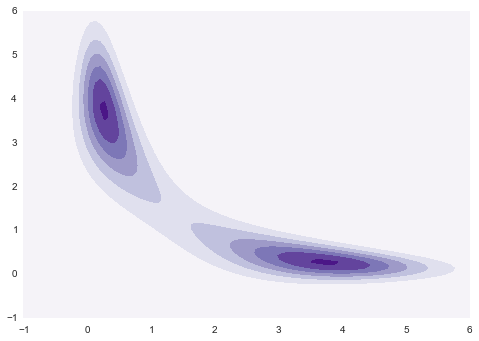

In [15]:
# Dan's think-through of the above example

# I need to know about the relevant domain of the posterior

p = lambda x, y: np.exp(-((x*y)**2 + x**2 + y**2 - 8*x - 8*y)/2.)

xvals_p, yvals_p = np.meshgrid(np.linspace(-1, 6, 100), np.linspace(-1, 6, 100))

plt.contourf(xvals_p, yvals_p, p(xvals_p, yvals_p), cmap="Purples")

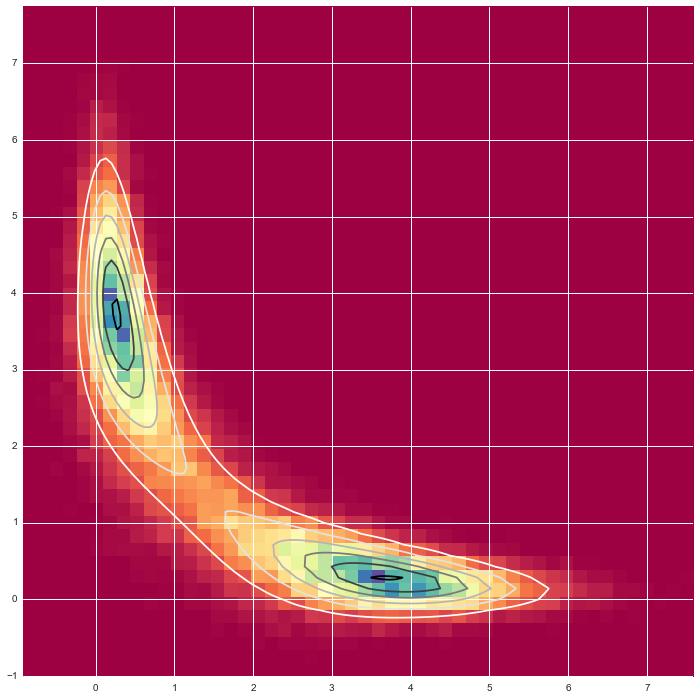

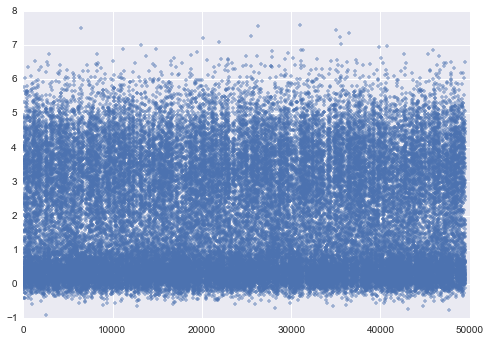

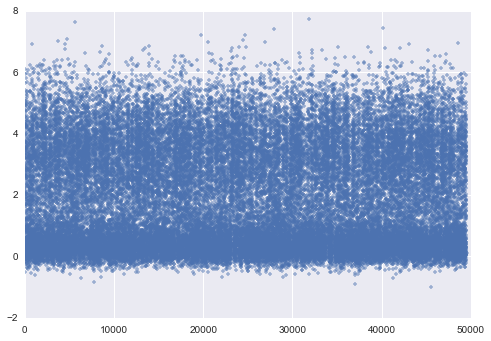

In [27]:
# Dan's think-through continuation

N = 50000

x_min = -1
x_max = 6
y_min = -1
y_max = 6

x = np.random.uniform(x_min, x_max)
y = np.random.uniform(y_min, y_max)

X, Y = [], []

for i in xrange(N):
    x = np.random.normal(loc=4./(1+y**2), scale=1/np.sqrt(1 + y**2))
    y = np.random.normal(loc=4./(1+x**2), scale=1/np.sqrt(1 + x**2))

    X.append(x); Y.append(y)

X, Y = X[500:-1], Y[500:-1]

plt.figure(figsize=[12,12])

plt.hist2d(X, Y, bins=50, cmap='Spectral')

plot_x, plot_y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max))

plt.contour(plot_x, plot_y, p(plot_x, plot_y), label=u'p(x,y)')
plt.show()

# traceplots
plt.plot(range(len(X)), X, '.', alpha=0.5)
plt.show()
plt.plot(range(len(Y)), Y, '.', alpha=0.5)
plt.show()

In [3]:
f= lambda x,y: np.exp(-(x*x*y*y+x*x+y*y-8*x-8*y)/2.)


First, let's make a contour plot of the posterior density.

<matplotlib.contour.QuadContourSet instance at 0x073D0738>

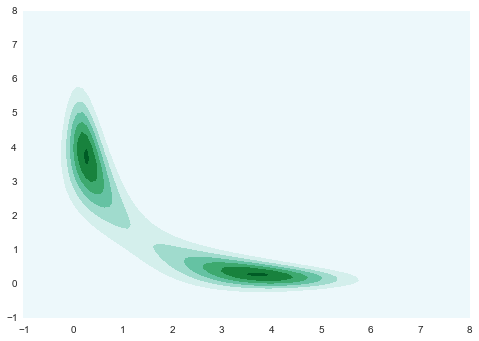

In [4]:
xx=np.linspace(-1,8,100)
yy=np.linspace(-1,8,100)
xg,yg = np.meshgrid(xx,yy)
z=f(xg.ravel(),yg.ravel())
z2 = z.reshape(xg.shape)
z2
plt.contourf(xg,yg,z2, cmap="BuGn")

Now let's run the sampler, by iteratively drawing from the conditional distribution of $x$ and $y$ given the other.

In [5]:
N = 50000
x=np.zeros(N+1)
y=np.zeros(N+1)
#Initialize x and y.
x[0]=1.
y[0]=6.
sig = lambda z,i: np.sqrt(1./(1.+z[i]*z[i]))
mu = lambda z,i: 4./(1.+z[i]*z[i])

for i in range(1,N,2):
    sig_x = sig(y,i-1)
    mu_x = mu(y,i-1)
    x[i] = np.random.normal(mu_x, sig_x)
    y[i] = y[i-1]
    
    sig_y = sig(x, i)
    mu_y = mu(x, i)
    y[i+1] = np.random.normal(mu_y, sig_y)
    x[i+1] = x[i]
    


To assess how the sampler is exploring the space, we can plot a **traceplot** for each dimension. A traceplot plots the value of each sample against the iteration number and gives a sense of how well the sampler is exploring the space.

In [6]:
def traceplot(z):
    plt.plot(range(len(z)),z,'.')

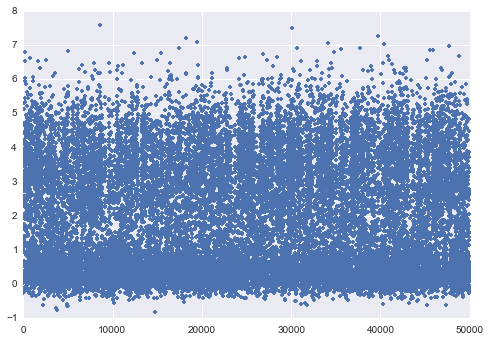

In [7]:
traceplot(x)

You can see from the traceplot of the sampling of $x$, that the sampler spends long periods of time near zero, and occasionally moves to and hangs out at higher values. These correspond to the two areas of high density in the countour plot.

We can also draw a histogram of $x$ to get an estimate of its **marginal distribution**.

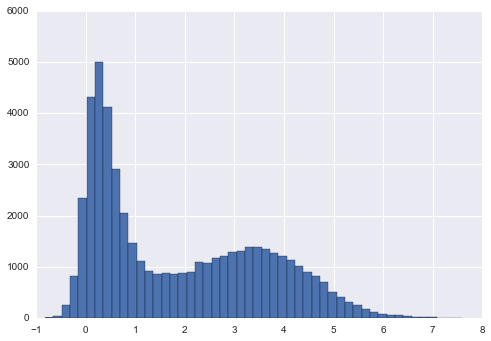

In [8]:
plt.hist(x, bins=50);

This is exactly what we would expect if we projected the distribution in the contour plot down to the $x$ axis.

We can do the same plots for $y$.

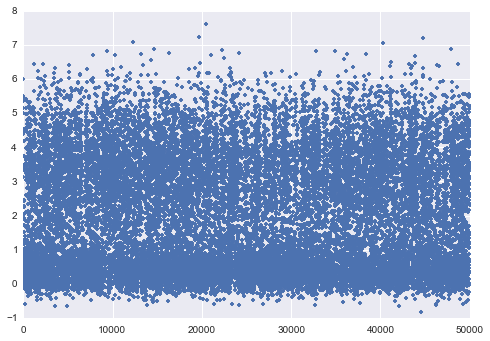

In [9]:
traceplot(y)

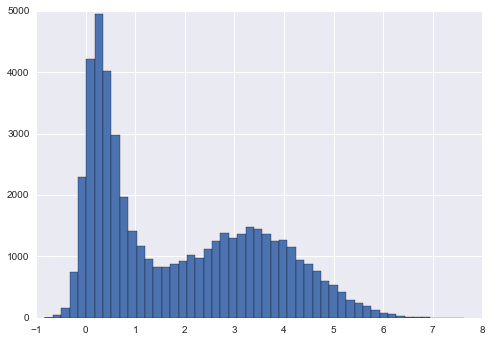

In [10]:
plt.hist(y, bins=50);

Because we are in two dimensions, we can also plot the path that the sampler took through the $xy$ plane. Note that the path always takes right angles, because we are alternating between moves that only move in the $x$ direction and only move in the $y$ direction.

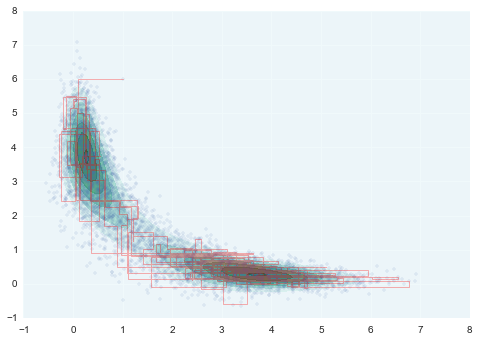

In [11]:
plt.contourf(xg,yg,z2, alpha=0.8, cmap="BuGn")
plt.plot(x[::10],y[::10], '.',alpha=0.1)
plt.plot(x[:300],y[:300], c='r', alpha=0.3, lw=1)

To see how effective the samples we have drawn will be at approximating summaries of the posterior distribution (for example the posterior mean), we can look at the autocorrelation of the samples. High autocorrelation would mean that the variance in the sample average that we take to approximate the posterior mean would be higher than expected if we had taken independent samples from the posterior distribution.

(0, 100)

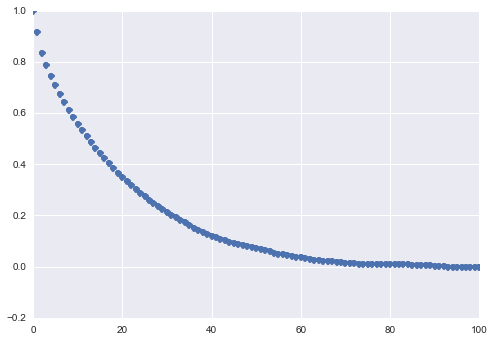

In [12]:
plt.acorr(x-np.mean(x), maxlags=100,  normed=True, usevlines=False);
plt.xlim( (0, 100))

(0, 100)

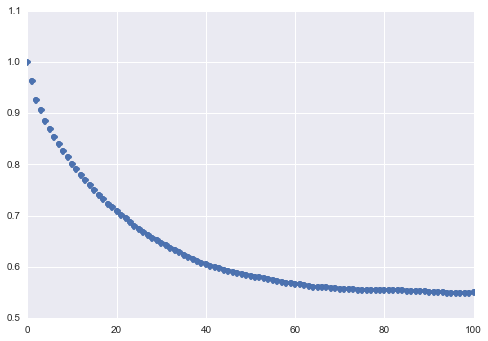

In [13]:
plt.acorr(x, maxlags=100,  normed=True, usevlines=False);
plt.xlim( (0, 100))

In [14]:
np.mean(x)

1.852565202550394

##Effective Sample Size

In both $x$ and $y$, we can see that the autocorrelation is quite high. This is not a big problem though because the sampler is so simple that we can draw millions of samples to make up for the high autocorrelation.

To figure out exactly how many samples we would have to draw, we can compute **effective sample size**, a measure of how many independent samples our  samples are equivalent to. This uses the same quantities that were used to compute the autocorrelation plot above. The following code is taken from https://code.google.com/p/biopy/source/browse/trunk/biopy/bayesianStats.py?r=67. You don't need to try to understand the function -- it's just here to run it, and this is a rather slow implementation.

In [42]:
def effectiveSampleSize(data, stepSize = 1) :
  """ Effective sample size, as computed by BEAST Tracer."""
  samples = len(data)

  assert len(data) > 1,"no stats for short sequences"
  
  maxLag = min(samples//3, 1000)

  gammaStat = [0,]*maxLag
  #varGammaStat = [0,]*maxLag

  varStat = 0.0;

  if type(data) != np.ndarray :
    data = np.array(data)

  normalizedData = data - data.mean()
  
  for lag in range(maxLag) :
    v1 = normalizedData[:samples-lag]
    v2 = normalizedData[lag:]
    v = v1 * v2
    gammaStat[lag] = sum(v) / len(v)
    #varGammaStat[lag] = sum(v*v) / len(v)
    #varGammaStat[lag] -= gammaStat[0] ** 2

    # print lag, gammaStat[lag], varGammaStat[lag]
    
    if lag == 0 :
      varStat = gammaStat[0]
    elif lag % 2 == 0 :
      s = gammaStat[lag-1] + gammaStat[lag]
      if s > 0 :
         varStat += 2.0*s
      else :
        break
      
  # standard error of mean
  # stdErrorOfMean = Math.sqrt(varStat/samples);

  # auto correlation time
  act = stepSize * varStat / gammaStat[0]

  # effective sample size
  ess = (stepSize * samples) / act

  return ess

Now we can compute effective sample size for x and y.

In [43]:
esx = effectiveSampleSize(x)
esy = effectiveSampleSize(y)
print "Effective Size for x: ", esx, " of ", len(x), " samples, rate of", esx/len(x)*100, "%."
print "Effective Size for y: ", esy, " of ", len(y), " samples, rate of", esy/len(y)*100, "%."

Effective Size for x:  1173.445748  of  50001  samples, rate of 2.34684455912 %.
Effective Size for y:  1203.5868639  of  50001  samples, rate of 2.40712558529 %.


Note that while the effective size is only just over 2% of the actual sample size, we can draw samples so quickly from the posterior that this is not a major hindrance. For estimating a quantity like a posterior mean (probably not a good idea in this case since the "center" of the distribution is not very meaningful) around 900 samples is more than enough.


The fundamental idea behind effective sample size is that the autocorrelation of the samples of the MCMC can give you enough information to determine how much thinning to do.  How? The formula for ESS is as follows for a MCMC chain X of sample size n:  

$$ ESS(X) = \frac{n}{1 + 2\sum_k \rho_k(X)} $$

where $\rho_k(X)$ is the autocorrelation coefficient at lag k for X.

To derive this metric we use two basic observations.  For a general time series $ Y_{mi} $ constructed by thinning every mth sample from $ Y_i $ (from the random variable Y) we can conclude by the Law of Large Numbers that 

$$ \hat{Y}_N = \sum_1^N Y_{mi} \rightarrow E[Y] $$ 

In addition we can observe (see Stochastic Simulation, Ripley (1987) on page 144) that:
$$ \var(\hat{Y}_N) \rightarrow \sigma^2[1 + 2\sum_k \rho_k(X)] $$

where $\sigma$ is the variance of $ Y_{mi} $

The form of ESS comes from observing that for large n, $ \var(\hat{Y}_N) $ converges to the same variance as for a sample of size ESS($Y_i$).

## Relationship to Metropolis Hastings

Gibbs sampling is in fact a specific case of the  Metropolis-Hastings algorithm
where the proposal $q$ is based on the following two stage procedure. 
First, a single dimension $k$ of $x$ is chosen. The proposed value $\xs_k$
is identical to ${\bf x}$ except  for its value along the $k$-dimension. $x_k$
is sampled from the conditional 
$$ q_k({\bf \xs}| {\bf \xt})=
\left\{
\begin{array}{cc}
 p(\xs_k| \xt_{-k})  \hspace{1cm}&   {\rm if} \,\, \xs_{-k}=\xt_{-k}  \\
0 & {\rm otherwise} 
\end{array}
\right.
 $$ 
 
 $$ q_k({\bf \xt}| {\bf \xs})=
\left\{
\begin{array}{cc}
 p(\xt_k| \xs_{-k})  \hspace{1cm}&   {\rm if} \,\, \xt_{-k}=\xs_{-k}  \\
0 & {\rm otherwise} 
\end{array}
\right.
 $$ 
 
 
where
$[\xt_{-k}=(\xt_1, \xt_2, \ldots, \xt_{k-1}, \xt_{k+1} ,\ldots, \xt_m)$.




$q_k(\xs_k| {\bf \xt}_k) = p(\xt_k| {\bf \xt}_{-k})$, where ${\bf x}_{-k}$ means all other 
components of $x$ but component $k$, i.e., the univariate conditional probabilities of each variable given all other variables. 

The acceptance probability is now:

\begin{eqnarray}
A_k( {\bf \xt}, {\bf \xs}) &=& \min\left[1, \frac{p({\bf \xs}) \, q_k({\bf \xt}|  {\bf \xs})}{p( {\bf \xt}) q_k( {\bf \xs}|  {\bf \xt} ) } \right]  \nonumber 
\end{eqnarray}
We can decompose the $q_k$'s and re-write the joint probability as a product of conditional and marginal distributions ($p({\bf \xs}) = p({\bf \xs_{-k}}, \xs_k)=p({\bf \xs_{-k}}) p(\xs_{k}| {\bf \xs_{-k}})$):


$$  \frac{p({\bf \xs}) \, q_k({\bf \xt}|  {\bf \xs})}{p( {\bf \xt}) q_k( {\bf \xs}|  {\bf \xt} )  }  
= \frac{[p({\bf \xs_{-k}}) p(\xs_{k}| {\bf \xs_{-k}})]\,p(\xt_k| {\bf \xs_{-k}})}{[p({\bf \xt_{-k}}) p(\xt_{k}| {\bf \xt_{-k}})]\,p(\xs_{k}| {\bf \xt_{-k}})}
= \frac{p({\bf \xt_{-k}}) p(\xs_{k}| {\bf \xt_{-k}})\,p(\xt_k| {\bf \xt_{-k}})}{p({\bf \xt_{-k}}) p(\xt_{k}| {\bf \xt_{-k}})\,p(\xs_{k}| {\bf \xt_{-k}})} =1
$$

Since the probabilities involving $x^{i}_{-k}$ and $\xs_{-k}$ are the same for all $k$, the
terms in the numerator and denominator directly cancel; therefore, the entire
expression is equal to 1. Gibbs sampling is thus equivalent to the Metropolis-
Hastings algorithm where the quantity $A_k$ is always equal to 1, a significant simplification.

####Example. evaluate the following integral 

$$ \int_0^1 \int_0^1 \int_0^1 xyz \ln(x+2y+3z) \sin(x+y+z) dx dy dz $$



Lets choose the distribution to draw from to be: $p(x,y,z) = \sin(x+y+z) /C $ , where $C$ is the normalization. 
$$
C=\int_0^1 \int_0^1 \int_0^1   \sin(x+y+z) dxdydz = \cos(3)-3\cos(2)+3\cos(1)-1 $$
That means we need to draw from $p(x)$ and then evaluate the integral 
$$ I = \frac{1}{N} \sum_{x_i,y_j,z_k} x_i y_j z_k \ln{(x_i+2y_j+3z_k)} $$
where $x_i, y_j, z_k$ are drawn from $p(x)$. 

The algorithm is then:

1. Initialize
2. t=1. Repeat: 
    1. generate $x_i,y_j, z_k$ from conditionals. $x^{(t+1)} \sim \sin(x+y^{(t)}+z^{(t)}) $ etc 
    2. Evaluate $h^{(t)} = C x^{(t+1)}y^{(t+1)}z^{(t+1)}\ln(x^{(t+1)}+2y^{(t+1)}+3z^{(t+1)})$
    3. $t= t+1$
3. $I= {\rm mean} (h)$

Finally we need to know how to generate samples from the conditionals. 
Let ${\bf X}=(X_1, X_2,X_3) = (x, y,z)$ and $X_{-i}$ be all the components but the $i$-th one. Let 

$$S_{-1} = \sum_{j \ne i} X_j.$$ 

The conditional probability is 

$$ p(X_i|X_{-1}) = C_i \sin(X_i+S_{-i}) $$

where $C_i$ is the normalization for the $i$-th component

$$  C_i  = \frac{1}{\cos(S_{-1}+1) - \cos(S_{-1})} $$

We then use the inverse transform 

$$ U =  \frac{1}{\cos(S_{-1}+1) - \cos(S_{-1})} \int_0^{X_i} \sin( S_{-1}+t ) dt = \frac{\cos(S_{-1}+X_i) - \cos(S_{-1})}{\cos(S_{-1}+1) - \cos(S_{-1})} $$
Inverting this, we get 

$$ X_i = \cos^{-1} \left[  \cos( S_{-i}) + U \cos(S_{-i}+1) -U \cos(S_{-i}) \right] -S_{-i} $$

In [65]:
N = 15000
C=np.cos(3)-3*np.cos(2)+3*np.cos(1)-1;


# start from 1/2,1/2,1/2
X = np.ones(3)/2.


# LOOP
h=np.zeros(N)
for n in xrange(N):
    i = np.floor(3*np.random.rand())  # select a random direction with p=0.33
    S_i = np.sum(X) - X[i]  # S_{-i}
    t = np.cos(S_i)
    U = np.random.rand()
    X[i] = np.arccos( t +U*np.cos(1+S_i)- U*t) - S_i
    h[n] = C*X[0]*X[1]*X[2]*np.log(np.dot([1, 2,  3],X))

print np.mean(h)



0.141547070055


##Example: Rats tumors (from [Gelman](http://www.stat.columbia.edu/~gelman/book/))


The below data is from tumors in female rats of type "F344" that recieve a particular drug, in 70 different experiments. 

The first column is the number that get the tumor; the second is the total number or rats tested

In [45]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

In [46]:
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
#print tumory, tumorn            

Now, a 71st experiment is done and we are told that 4 out of 14 rats develop tumors. Our problem is  to estimate the risk of tumor $\theta_{71}$ in these rats. 

Since we have historical data from 70 previous experiments to rely on, we can use that data to help us make this estimate, in a Bayesian manner, by calculating the posterior for $\theta_{71}$. 

In the $j$-th historical experiment, let the number of rats with tumors be $y_j$ and the total number of rats be $n_j$.
Since the rats either have or dont have the tumor, it makes sense to use a Binomial Model for **each** experiment, assumes a sample size $n_j$ and a probability $\theta_j$ that a rat has a tumor. For any one of the experiments

$$p(y_i|\theta_i; n_i) =  Binom(n_i, y_i, \theta_i) $$

and for all the data we have, using $Y=[y_1,\ldots, y_{70}]$ and $\Theta = [\theta_1, \ldots, \theta_{70}]$ and I use the notation
$\{n_i\} =[n_1, \ldots, n_{70}]$

$$ p(Y|\Theta; \{n_i\}) =  \prod_{i=1}^{70}Binom(n_i, y_i, \theta_i) $$


We now need to choose a prior $p(\Theta)$. Our first thought might be to use a Beta (conjugate prior to Binomial) for each $\theta_i$, i.e.

$$ \theta_i \sim Beta(\alpha_i, \beta_i).$$

$$p(\Theta| \{\alpha_i\}, \{\beta_i\}) = \prod_{i=1}^{70} Beta(\theta_i, \alpha_{i}, \beta_{i}),$$

where $\alpha_i$ and $\beta_i$ are what we called **hyperparameters**. Again I use the notation $\{\alpha_i\}=[\alpha_1, \ldots, \alpha_{70} ]$ and similarly for $\{beta\}$.

However, we would then come up with a very overfit model with 210 parameters and not much data. Besides, there are likely outliers in some experiments, small sample sizes, etc (this is called unpooled).

The other extreme is to assume that there is only one $\theta$ in the problem, and set an prior on it, making this a three parameter problem. This ignores any variation amongst the sampling units other than sampling variance, and such a model might thus be underfit, unable to capture the variations in the samples (complete pooling).

Let us compromise and assume that the $\theta_i$s are drawn from a "population distribution" given by a conjugate Beta prior $Beta(\alpha, \beta)$ with parameters $\alpha$ and $\beta$ to describe this data (partial pooling).

$$ \theta_i \sim Beta(\alpha, \beta).$$

$$p(\Theta | \alpha, \beta) = \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta).$$

This structure is shown in the diagram below.

<img src="./Lecture09_data/hier.png" width="320" height="240"/>

Such a model is called a **hierarchical** model, with observable outcomes modeled conditionally on certain parameters($\theta$s) which themselves are given a probabilistic specification in terms of further parameters ($\alpha$ and $\beta$), known as **hyperparameters**.

Modeling in this way has two advantages: (a) as we shall see, it helps us develop a computational strategy to solve the problem, and (b) it allows estimates of the probabilities of any one of the units (here, one of the experiments) to borrow strength from all the data as a whole through the estimation of the hyperparameters. In other words, if some of the experiments had lower sample sizes or other outlier like behavior, the procedure helps "regularize" this.

Thus, our basic question is: How do we find $\alpha$ and $\beta$ and thus find $\theta$ or the tumor risk?. 

We will first make an pseudo-Bayesian estimate, and then progress onto a fully bayesian calculation. 

### Pseudo-Bayesian estimate
Assuming that $\alpha$ and $\beta$ are known, we can write out analytically the *posterior distribution* for each of the first 70 $\theta_i$s,  $p(\{\theta_i\} | y_i, n_i, \alpha, \beta)$ given the data $Y$, $\alpha$, and $\beta$:

$$p(\theta_i | y_i,n_i,\alpha, \beta) = Beta(\alpha + y_i, \beta + n_i - y_i)$$

This works because conditional on knowing $\alpha$ and $\beta$, our model for each of our experiments (through the drawn $\theta_i$) is independent from the other. 




### An approximation
Let us now use an approximation to find values of $\alpha$ and $\beta$ using the entire population. The technique below is known as **moment matching** and is an approximation to a full bayesian analysis.

For the parameters of a Beta distribution we have:

$$\alpha + \beta = \frac{{\rm E}(\theta)\,(1 - {\rm E}(\theta))}{{\rm var}(\theta)} - 1 $$

and 

$$\alpha = (\alpha + \beta) \, {\rm E}(\theta), \,\,\,\,\,   \beta = (\alpha + \beta)\,(1 - {\rm E}(\theta)) .$$



In [47]:
#pseudo Bayesian estimates
tumor_rat = [float(e[0])/float(e[1]) for e in zip(tumory, tumorn)]
tmean = np.mean(tumor_rat)
tvar = np.var(tumor_rat)
print "Theta mean=",tmean, "Variance of theta =", tvar


aplusb = tmean*(1-tmean)/tvar - 1
a=aplusb*tmean
b=aplusb*(1.0 - tmean)
print "alpha=", a, "beta=", b

Theta mean= 0.13600653889 Variance of theta = 0.0105576406236
alpha= 1.37777483929 beta= 8.75243544715


#### Posterior for pseudo-Bayesian 
Using those estimates we can also write the posterior for the 71st experiment and see how posterior median compares to the raw fraction of 4 rats with tumors out of 14 from the 71st experiment.

From above
$$p(\theta_{71} | y_{71},n_{71},\alpha, \beta) = Beta(\alpha + y_{71}, \beta + n_{71} - y_{71})$$

where $\alpha, \beta$ take the values that we calculated above.


In [48]:
from scipy.stats import beta
from scipy.stats import norm
beta_current = beta(a+4,b+14-4)
print beta_current
bcrvs=beta_current.rvs(size=1000)
# Calculate the confidence interval
np.percentile(bcrvs,[2.5,50.0, 97.5]), 4.0/14.0

([0.07797072665518813, 0.2145278157214178, 0.4063999521905004],
 0.2857142857142857)

We can already see that the raw fraction probably overestimates the true tumor in the 71st experiment.
Remember this is not a full bayesian treatment.

### Full Bayesian Treatment

To do that we need to specify a **hyper-priors** $p(\alpha, \beta)$ on these hyperparameters ($\alpha, \beta$). The idea of the hyper-prior is the same as that of a prior; except that the hyperpriors are priors on prior parameters.  We typically use uninformative hyperpriors: indeed this is one of the key strategies of hierarchical modelling: un-informative priors are pushed down the prior hierarchy.

We then write out a joint posterior distribution for the $\theta$s, $\alpha$ and $\beta$.

$$p( \theta_i, \alpha, \beta | y_i, n_i) \propto p(\alpha, \beta) \, p(\theta_i | \alpha, \beta) \, p(y_i | \theta_i, n_i,\alpha, \beta)$$

or for the whole dataset:

$$ p( \Theta, \alpha, \beta | Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

Note that this is a high dimensional problem: there are 72 parameters (70 $\theta$s and $\alpha , \beta$).

The conditional posterior distribution for each of the $\theta_i$, given everything else is a Beta distribution itself (remember Beta is conjugate prior to Bionomial).

$p(\theta_i | y_i, n_i, \alpha, \beta) = Beta(\alpha + y_i, \beta + n_i - y_i)$ 


For each of $\alpha$ and $\beta$, given everything else, the posterior distributions can be shown to be:

$$p(\alpha | Y, \Theta ,\beta ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)}\right)^N \prod_{i=1}^{N} \theta_i^{\alpha}$$

$$P(\beta | Y, \Theta ,\alpha ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\beta)}\right)^N \prod_{i=1}^{N} (1 - \theta_i)^{\beta}$$

Note: The conditional posteriors do depend on $Y$ and $\{n\}$ via the $\theta$'s. 

### Choosing a hyperprior

The 'prior' mean $\mu$ of the beta population distribution for $\{\theta_i\}$ is given by $\frac{\alpha}{\alpha + \beta}$, and the variance is given by $\frac{\mu (1-\mu)}{\alpha +\beta +1}$. It makes sense to independly choose uninformative, uniform priors on the mean and the standard deviation in units of the mean. 

We thus choose to set up a uniform prior on 

$$\left(\frac{\alpha}{\alpha + \beta}, (\alpha + \beta)^{-1/2}\right),$$

(the second is approximate) which when multiplied by the Jacobian of the transformation from $(\alpha, \beta)$ yields  a hyperprior $p(\alpha, \beta) \sim (\alpha + \beta)^{-5/2}$.  

This is not the only scheme via which an uninformative hyperprior distribution which will be dominated by the likelihood can be set, and it is worth eploring other options, such as other powers of $(\alpha + \beta)$.



### Sampling

We construct a combined Gibbs sampler and MH sampler using the above conditionals: the draws for the $\theta_i$ is simple because of conjugacy. But for $\alpha$ and $\beta$, we implement a Metropolis-Hastings sampler, use a normal proposal with mean the current values of $\alpha$ and $\beta$  and standard deviations 0.25 and 3 respectively, remembering to reject negative values from the proposal. Each step of the 70 gibbs samplers are alternated with each step of the MH sampler for $\alpha$ and $\beta$. 



In [49]:
# number of thetas
numthetas=tumorn.shape[0]

We set up python functions for each draw

In [50]:
from scipy.special import gammaln

# prior for the hyperparameters
log_prior = lambda a,b: -2.5*np.log(a + b)


# sampling from conditional posterior for the theta
draw_thetas = lambda a,b: beta.rvs(a+tumory,b+tumorn-tumory, size=numthetas)

# conditional posterior (pdf) for alpha
def log_cond_alpha(a,b, thetas):
    return numthetas*(gammaln(a+b) - gammaln(a)) + a*np.sum(np.log(thetas)) + log_prior(a,b)
   
# conditional posterior (pdf) for beta
def log_cond_beta(a,b, thetas):
    return numthetas*(gammaln(a+b) - gammaln(b)) + b*np.sum(np.log(1.0 - thetas)) + log_prior(a,b)
  
# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha(a,b,thetas,proposal_sd, accepts):
    astar = norm.rvs(a,proposal_sd)  # proposed a new alpha
    num = log_cond_alpha(astar,b, thetas) 
    den = log_cond_alpha(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den) and (astar >0):#little built in rejection
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return a

def draw_beta(a,b,thetas,proposal_sd, accepts):
    bstar = norm.rvs(b,proposal_sd)
    num = log_cond_beta(a,bstar, thetas)
    den = log_cond_beta(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den) and (bstar >0):#little built in rejection
        accepted=1
    else:
        accepted=0
    accepts['beta'] = accepts['beta'] + accepted
    if accepted:
        return bstar
    else:
        return b

We initialize variables for our sampler.

In [51]:
burnin=20000
numtraces=200000
totaltraces=burnin+numtraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
thetas=np.empty((totaltraces, numthetas))

alpha_prop_sd=0.25
beta_prop_sd=3.
alphas[0]=1.
betas[0]=1.
thetas[0,:] = (tumory+0.5)/(tumorn+0.5)
#draw_thetas(alphas[0], betas[0])
accepteds={'alpha':0, 'beta':0}

This is the main loop of our sampler. Notice the structure: for alpha we take from the previous step, for beta we take the changed alpha from the current step, and for the thetas we take both alpha and beta from the current step.

In [52]:
for m in np.arange(1,totaltraces):
    alphas[m] = draw_alpha(alphas[m-1],betas[m-1],thetas[m-1,:], alpha_prop_sd, accepteds)
    betas[m] = draw_beta(alphas[m],betas[m-1],thetas[m-1,:], beta_prop_sd, accepteds)
    thetas[m,:] = draw_thetas(alphas[m],betas[m])


Check our acceptance ratio, and then remove burnin samples and thin

In [53]:
accepteds['alpha'], accepteds['beta'], totaltraces

(129892, 90728, 220000)

In [54]:
alphatrace=alphas[burnin+1:totaltraces:20]
betatrace=betas[burnin+1:totaltraces:20]
thetastrace=thetas[burnin+1:totaltraces:20,:]
print thetastrace.shape, alphatrace.shape

(10000, 70) (10000,)


#### Traces and autocorrelation
We check our traces and autocorrelation.

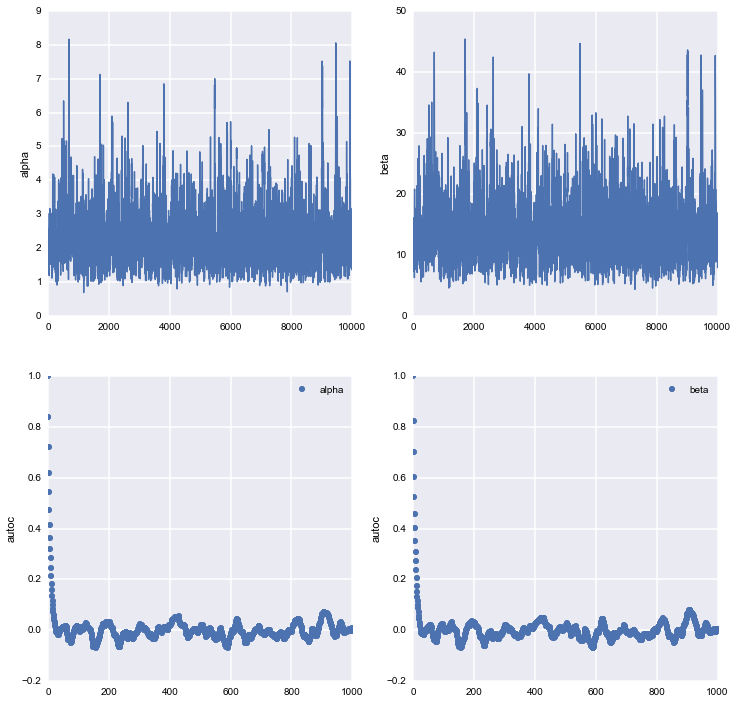

In [55]:
plt.figure(figsize=[12,12])
plt.subplot(2,2,1)
plt.plot(alphatrace)
plt.ylabel('alpha')
plt.subplot(2,2,2)
plt.plot(betatrace)
plt.ylabel('beta')
plt.subplot(2,2,3)
plt.acorr(alphatrace-np.mean(alphatrace), normed=True, usevlines=False, maxlags=1000, label=u'alpha')

plt.xlim( (0,1000))
plt.ylabel('autoc')
plt.legend()
plt.subplot(2,2,4)
plt.acorr(betatrace-np.mean(betatrace), normed=True, usevlines=False, maxlags=1000, label=u'beta')

plt.xlim( (0,1000))
plt.ylabel('autoc')
plt.legend()

### Plots of the posterior

We plot the $\alpha$ and $\beta$ marginals and create a 2D histogram or KDE plot (`sns.kdeplot` in seaborn) of the marginal posterior density in the space $x = \alpha/\beta$, $y = log(\alpha + \beta)$. We also see the marginal of $\theta_1$.

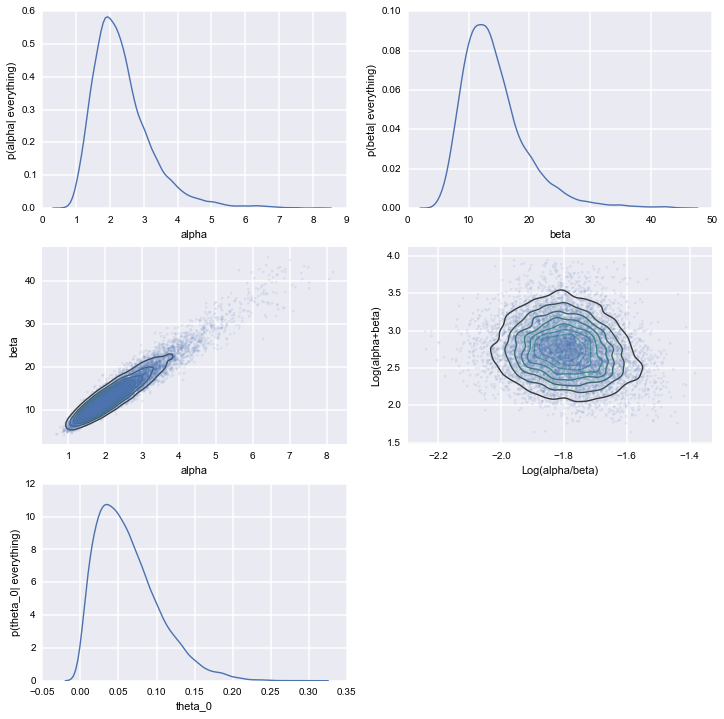

In [56]:
plt.figure(figsize=[12,12])
plt.subplot(3,2,1)
sns.kdeplot(alphatrace)
plt.xlabel('alpha')
plt.ylabel('p(alpha| everything)')
plt.subplot(3,2,2)
sns.kdeplot(betatrace)
plt.xlabel('beta')
plt.ylabel('p(beta| everything)')
plt.subplot(3,2,3)
plt.plot(alphatrace, betatrace,'.', alpha=0.1)
sns.kdeplot(alphatrace, betatrace)
plt.xlabel('alpha')
plt.ylabel('beta')

plt.subplot(3,2,4)
plt.plot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace),'.', alpha=0.1)
sns.kdeplot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace))
plt.xlabel('Log(alpha/beta)')
plt.ylabel('Log(alpha+beta)')

plt.subplot(3,2,5)
sns.kdeplot(thetastrace[:,0])
plt.xlabel('theta_0')
plt.ylabel('p(theta_0| everything)')

Note: The point estimates from the full Bayesian analysis are somewhat different from those of our earlier estimations.

In [57]:
print np.median(alphatrace), np.median(betatrace), a,b

2.19596237165 13.2744446106 1.37777483929 8.75243544715


### Understanding the posterior

We plot the observed tumor rates on the x-axis against posterior medians for each of the 70 $\theta$'s on the y axis, along with error bars obtained from finding the 2.5 and 97.5 percentiles. 



In [58]:
percentiles=np.percentile(thetastrace, [2.5,50.0, 97.5], axis=0)
lowerthetas, medianthetas, upperthetas=percentiles
elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

In [59]:
ratios=tumory.astype(float)/tumorn

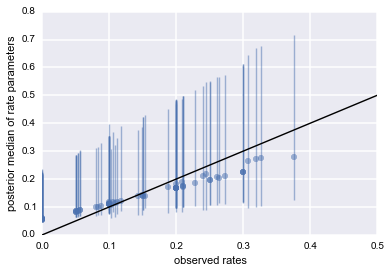

In [60]:
plt.errorbar(ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior median of rate parameters")

### The 71st experiment

In a hierarchical model, there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $\tilde{y}$ given a $\theta_i$, and (2) The distribution of observations $\tilde{y}$ drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).

We wish to understand what happens for the 'future' $\theta_{71}$.

We finally, compare the posterior prediction for the 71st experiment with what we found in the approximation.

In [61]:
n_pos_samples=alphatrace.shape[0]
n_samples_per_param=1000
from scipy.stats import binom

# LIKELIHOOD
like = lambda theta71: binom.pmf(4, 14, theta71)  
#lets do (a) theta71 factorizes out
posterior71 = np.empty((n_pos_samples, n_samples_per_param))

In [62]:
for i in xrange(n_samples_per_param):
    posterior71[:,i]=beta.rvs(alphatrace+4, betatrace+10)

In [63]:
percentiles=np.percentile(posterior71, [2.5,50.0, 97.5])

# bvrvp are from the pseudo-Bayes 
bvrvp=np.percentile(bcrvs, [2.5,50.0, 97.5])
print percentiles, bvrvp, 4.0/14

[0.086005162083964137, 0.20253843800544882, 0.37793400306664687] [0.07797072665518813, 0.2145278157214178, 0.4063999521905004] 0.285714285714


In [64]:
print percentiles[2]-percentiles[0], bvrvp[2] - bvrvp[0]

0.291928840983 0.328429225535


The posterior 95% spread from the full analysis is just a bit narrower, with the median being slightly lower.